In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [42]:
topics = pd.read_csv("../data/topics_labeled.csv")
interactions = pd.read_csv("../data/interactions_with_topic_probs.csv")
political_topics = topics.loc[topics["Politics"]==1, "Name"].to_list()
personality_topics = topics.loc[topics["Personality"]==1, "Name"].to_list()

interactions["politics_queries"] = interactions[political_topics].sum(axis=1)
interactions["personality_queries"] = interactions[personality_topics].sum(axis=1)
user_topics_bert = interactions.groupby(["user_id"])[["politics_queries", "personality_queries"]].mean()

In [43]:
df = pd.read_csv("../data/survey_results.csv")
df = df[df["context"]==1]
df = df[["model", "participant", "task", "understanding", "gender", "political_lean"]].drop_duplicates()
df["user_id"] = df["participant"]
df["is_man"] = (df["gender"]=="man").astype(int)
df["has_left_politics"] = (df["political_lean"].isin(["Liberal", "Very Liberal"])).astype(int)

df = df[["understanding", "model", "task", "user_id", "is_man", "has_left_politics"]]
df = df.merge(user_topics_bert, on="user_id", how="left")

user_topics_survey = pd.read_csv("../data/user_topics.csv")
df = df.merge(user_topics_survey, on="user_id", how="left")

df.to_csv("../data/regression/understanding.csv", index=False)
df.columns

Index(['understanding', 'model', 'task', 'user_id', 'is_man',
       'has_left_politics', 'politics_queries', 'personality_queries',
       'factual_info', 'personal_advice', 'writing', 'recommendations',
       'coding', 'news_or_politics'],
      dtype='object')

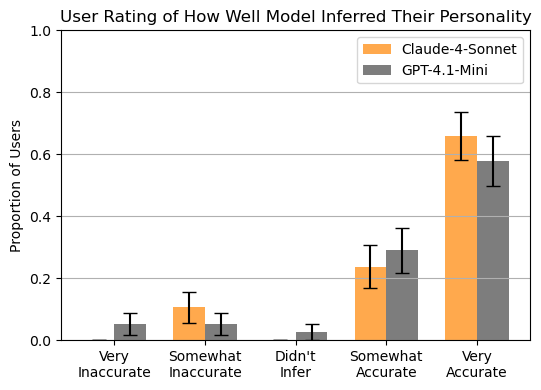

In [53]:
TASK = "aita"

df = pd.read_csv("../data/survey_results.csv")
df = df[df["context"]==1]
df = df[["model", "participant", "task", "understanding"]].drop_duplicates()

df = df[df["task"]==TASK]
understanding_labels = {
    1: "Very\nInaccurate",
    2: "Somewhat\nInaccurate",
    3: "Didn't\nInfer",
    4: "Somewhat\nAccurate",
    5: "Very\nAccurate"
}
df['understanding'] = df['understanding'].map(understanding_labels)
counts = df.groupby(['understanding', 'model']).size().unstack(fill_value=0)

# Reorder labels
ordered_labels = ["Very\nInaccurate", "Somewhat\nInaccurate", "Didn't\nInfer", "Somewhat\nAccurate", "Very\nAccurate"]
counts = counts.reindex(ordered_labels)
counts = counts.fillna(0)
# Total per context group (needed for proportions and SE)
totals = counts.sum()

# Compute proportions
proportions = counts.div(totals)

# Compute standard errors for binomial proportions: SE = sqrt(p * (1 - p) / n)
se = np.sqrt(proportions * (1 - proportions) / totals)

# Plot
fig, ax = plt.subplots(figsize=(5.5, 4))
bar_width = 0.35
x = np.arange(len(proportions))

# Plot each bar with error bars
ax.bar(x - bar_width/2, proportions["claude-sonnet-4-20250514"], width=bar_width, yerr=se["claude-sonnet-4-20250514"], capsize=5, color="#FFA94D", label='Claude-4-Sonnet')
ax.bar(x + bar_width/2, proportions["gpt-4.1-mini-2025-04-14"], width=bar_width, yerr=se["gpt-4.1-mini-2025-04-14"], capsize=5, color="#7D7D7D", label='GPT-4.1-Mini')

ax.set_ylim(0,1)
ax.set_xticks(x)
ax.set_xticklabels(proportions.index, rotation=0)
xlabel = "User Rating of How Well Model Inferred Their Politics"
if TASK == "aita":
    xlabel = "User Rating of How Well Model Inferred Their Personality"
ax.set_title(xlabel)
ax.set_ylabel('Proportion of Users')
ax.legend()
plt.gca().yaxis.grid(True, linestyle="-")  # optional readability

plt.tight_layout()
plt.savefig(f"figures/understanding_{TASK}.jpg", dpi=300, bbox_inches="tight")
plt.show()